<h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 2 of 4</p>

1. [Problem Statement](#problem)
2. [Question 2](#question)
3. [Cleaning](#cleaning)
4. [Analysis](#analysis)
5. [Visualization](#visualize)
6. [Concluding Remarks](#conclusion)

<a id="problem"></a>
# Problem Statement
---

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

<a id="question"></a>
# Question 2
---

Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

## Approach
Analyze the data to see if there is a higher correlation between the HEATING complaints and any particular borough, ZIP code, or street.

## Load Data
Separately the [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

In [1]:
import pandas as pd
df = pd.read_pickle('C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\ny311full.pkl') # Local
#df = pd.read_pickle('./ny311.pkl') #IBM Cloud / Watson Studio
df.shape

(5862383, 15)

<a id="cleaning"></a>
# Cleaning
---

<p style="color:Red;"><b>Note</b>:  This section became very large.  Before submitting, I cut out much of it, but it is still over half the notebook.  If desired:

[SKIP TO NEXT SECTION](#analysis)

## Reduce data to relevant rows and columns

In [2]:
#Remove rows that were not for the complaint types identified in question one.
df.drop(df[df["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==False].index, inplace=True)
#Remove columns deemed unnecessary for this question.
df.drop(['created_date','complaint_type','resolution_description','closed_date','location_type','status','address_type'], axis=1, inplace=True)

## Standardization

Change values from different sources into the same format, units, or convention

### General standardization

In [3]:
#Normalize all strings to uppercase so different casing won't appear as separate values.
df['incident_address'] = df['incident_address'].str.upper()
df['street_name'] = df['street_name'].str.upper()
df['city'] = df['city'].str.upper()
df['borough'] = df['borough'].str.upper()

### Borough standardization

In [4]:
df['borough'].value_counts()

BRONX            569960
BROOKLYN         543166
MANHATTAN        398552
UNSPECIFIED      282917
QUEENS           228447
STATEN ISLAND     17419
Name: borough, dtype: int64

<p style="color:Red;"><b>Insight</b>:  When the borough is UNSPECIFIED it appears to mean that often either the borough <i>or even a "neighborhood" (a division below borough)</i> has been entered in the CITY column.  The city is actually "correct" with NEW YORK only 59K times.  The city column is a de-facto "neighborhood" column for the most part.</p>

In [5]:
#Correct rows where borough was entered in the city column with "UNSPECIFIED" in the borough column.
import numpy as np
five_boroughs = ["BROOKLYN","BRONX","MANHATTAN","QUEENS","STATEN ISLAND"]
which_rows_to_adjust = df[(df["borough"]=='UNSPECIFIED')&df["city"].isin(five_boroughs)].index
df.loc[which_rows_to_adjust,'borough']=df.loc[which_rows_to_adjust,'city']
df.loc[which_rows_to_adjust,'city']=np.nan
#Drop a few rows of ambiguous data.
df.drop(df[(df["borough"]=='MANHATTAN')&(df["city"]=='BRONX')].index, axis=0, inplace=True)
#Fill in UNSPECIFIED borough when city was entered as NEW YORK.
which_rows_to_adjust = df[(df["borough"]=='UNSPECIFIED')&(df["city"]=='NEW YORK')].index
df.loc[which_rows_to_adjust,'borough']="MANHATTAN"
df.loc[which_rows_to_adjust,'city']=np.nan
#Although the city for most of the "NEW YORK" ones are the only ones that technically got the "city" column valued correctly,
#since every other row uses city as "neighborhood":  Standardize these.
which_rows_to_adjust = df[(df["city"]=='NEW YORK')].index
df.loc[which_rows_to_adjust,'city']=np.nan

<p style="color:Red;"><b>Decision</b>:  There are still 38K rows with unspecified boroughs, but the neighborhoods are in the city column, so use them to map to boroughs.</p>

In [6]:
#See the neighborhoods of the still unspecified boroughs.
neighborhoods = df[(df['borough']=='UNSPECIFIED')&(df['city'].isnull()==False)]['city'].unique()
neighborhoods.sort()

In [7]:
#All the neighborhoods above are in Queens according to Wikipedia.
#Standardize borough for these rows with unspecified borough that are in Queens.
which_rows_to_adjust = df[(df["borough"]=='UNSPECIFIED')&df["city"].isin(neighborhoods)].index
df.loc[which_rows_to_adjust,'borough']="QUEENS"
df['borough'].value_counts()

BRONX            658545
BROOKLYN         636554
MANHATTAN        457638
QUEENS           266565
STATEN ISLAND     20881
UNSPECIFIED         269
Name: borough, dtype: int64

<p style="color:Red;"><b>Insight</b>:  The above are some preliminary raw numbers to partially answer part of the the question.</p>

In [8]:
#Fix rows with unspecified borough and no other practical information from which to derive it.
which_rows_to_adjust = df[(df["borough"]=='UNSPECIFIED')&df["city"].isnull()].index
df.loc[which_rows_to_adjust,'borough']=np.nan

In [9]:
#Fix rows with city (neighborhood) equal to borough
which_rows_to_adjust = df[(df["borough"]==df["city"])].index
df.loc[which_rows_to_adjust,'city']=np.nan

In [10]:
#Fix rows with city that started off null or was adjusted subsequently to be null
which_rows_to_adjust = df[df["city"].isnull()].index
df.loc[which_rows_to_adjust,'city']="Unspecified"

<p style="color:Red;">At this point borough is reasonably populated with all the UNSPECIFIED and weird cases standardized.</p>

### ZIP Code standardization

<p style="color:Red;"><b>Insight</b>:  The zip codes are all float64.  All of them have zero after the decimal point.  They are all five digits before the decimal point.  Almost 19K of the 2 Million+ rows are null.</p>

<p style="color:Red;"><b>Decision</b>:  None are deemed wrong, and there is not a convenient way to obtain values for the missing ones.  So no adjustments.</p>

### Street

<p style="color:Red;"><b>Insight</b>:  Before any attempt at standardization, there were 5980 distinct street_name values in the data.  There was already some clues the same street may show up in more than one form.

<p style="color:Red;"><b>Goal</b>:  Standardize the street names as much as possible.  The goal being so different representations of the same street are all totaled together as the same street.</p>

In [11]:
# There is one row with a null street, so drop it to avoid errors standardizing it.
df.drop(df[df["street_name"].isnull()].index, axis=0, inplace=True)

#### Insights
Documented here in Python code form, so the "documentation" can also later be run to standardize the street names.

In [12]:
# Some street values have multiple spaces in a row.
import re
def standardize_spaces(raw):
    result = raw.strip() #Remove leading and trailing spaces.
    result = re.sub(' +', ' ', result) #Squeeze multiple adjacent spaces into just one space.
    return result

In [13]:
# Some streets have problematic characters.  For example:  ST. ANN'S AVENUE also exists without period or apostophe.
problem_characters = ['.', '\'']
def replace_problem_characters(raw):
    result = raw
    for (character) in problem_characters:
        result = result.replace(character,'')
    return result

In [14]:
#Streets are not always called a "street".
street_suffixes = ["STREET","AVENUE","BOULEVARD","PLACE","ROAD","PARKWAY","CONCOURSE","DRIVE","TERRACE","HIGHWAY","PARK",
                   "EXPRESSWAY","SQUARE","PLAZA","OVAL","CRESCENT","LANE","COURT","EXTENSION","TURNPIKE", "LOOP", "ESTATE", "WAY"]

In [15]:
#Streets often have a directional element.  Can be different parts of the same street or entirely different streets.
street_directionals = ["SOUTH","NORTH","EAST","WEST","SOUTHWEST","NORTHWEST","SOUTHEAST","NORTHEAST"]

In [16]:
#Some words are sometimes entered in a non-standard way or with typos need to be standardized.
word_replacements = [("AVE","AVENUE"),("ST","STREET"),("RD","ROAD"),("FT","FORT"),("BX","BRONX"),("MT","MOUNT"),
                     ("NICHLAS","NICHOLAS"),("NICHALOS","NICHOLAS"),("EXPRE","EXPRESSWAY"),("HARACE","HORACE"),
                     ("NO","NORTH"),("AV","AVENUE"),("CRK","CREEK"),("FR","FATHER"),("JR","JUNIOR"),("GR","GRAND"),
                     ("CT","COURT"),
                     ("SR",""), # Service Road.  These are always near a similarly named street.  Lump together.
                     ("QN","QUEENS"),
                     ("ND",""), # A space between a number and ND such as EAST 52 ND STREET.  Note ST and RD can be street or road.
                     ("PO","POND"),("BO","BOND"),("GRA","GRAND"),("REV","REVEREND"),("CO-OP","COOP"),
                     ("GRANDCONCOURSE", "GRAND CONCOURSE"),("CENTRL", "CENTRAL"),("BLVD","BOULEVARD"),
                     ("FREDRICK", "FREDERICK"),("DOUGLAS", "DOUGLASS"),("MALCOM", "MALCOMN"),
                     ("NORTHEN", "NORTHERN"),("AVNEUE","AVENUE")]
def replace_words(raw):
    split_raw = raw.split()
    for (old, new) in word_replacements:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==old), None)
        if found_at_index!=None:
            split_raw[found_at_index] = new
            return standardize_spaces(" ".join(split_raw))
    return raw

In [17]:
#Abbreviations that are sometimes not abbreviations.  
#Only replace them if they are not part of a two word street.
#Example:  Change 55 AVENUE N to 55 AVENUE NORTH but do not change AVENUE N to AVENUE NORTH.
abbreviation_replacements = [("N","NORTH"),("S","SOUTH"),("E","EAST"),("W","WEST"),("SW","SOUTHWEST"),
                             ("NW","NORTHWEST"),("SE","SOUTHEAST"),("NE","NORTHEAST")]
def replace_tricky_abbreviations(raw):
    split_raw = raw.split()
    if len(split_raw)!=2:  # AVENUE N, E STREET, etc.
        for (old, new) in abbreviation_replacements:
            found_at_index = next((i for i, x in enumerate(split_raw) if x==old), None)
            if found_at_index!=None:
                split_raw[found_at_index] = new
                return " ".join(split_raw)
    return raw

In [18]:
#Some words are actually prefixes of the following word.  Example the LA prefix of LA GRANGE.
word_prefixes = ["DE","MC","LA","VAN","MAC","CO"]
def concatenate_prefixes(raw):
    split_raw = raw.split()
    last_word = len(split_raw) - 1
    for (prefix) in word_prefixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==prefix), None)
        if found_at_index!=None:
            if len(split_raw)>1:
                if found_at_index != last_word:
                    split_raw[found_at_index] = ''
                    split_raw[found_at_index+1] = prefix + split_raw[found_at_index+1]
                    return standardize_spaces(" ".join(split_raw))
    return raw

In [19]:
#Some phrases need custom replacement because they involve multiple words or easily mis-interpretted out of context.
phrase_replacements = [("DR M L KING JR","MARTIN LUTHER KING"),("DR MARTIN L KING","MARTIN LUTHER KING"),
    ("MARTIN LUTHER KING","MARTIN LUTHER KING"),("MARTIN L KING JR","MARTIN LUTHER KING"),
    ("MARTIN L KING","MARTIN LUTHER KING"),("ST NICHOLAS","SAINT NICHOLAS"),("ST JOHN","SAINT JOHN"),
    ("ST MARK","SAINT MARK"),("ST ANN","SAINT ANN"),("ST LAWRENCE","SAINT LAWRENCE"),("ST PAUL","SAINT PAUL"),
    ("ST PETER","SAINT PETER"),("ST RAYMOND","SAINT RAYMOND"),("ST THERESA","SAINT THERESA"),("ST FELIX","SAINT FELIX"),
    ("ST MARY","SAINT MARY"),("ST OUEN","SAINT OUEN"),("ST JAMES","SAINT JAMES"),("ST GEORGE","SAINT GEORGE"),
    ("ST EDWARD","SAINT EDWARD"),("ST CHARLES","SAINT CHARLES"),("ST FRANCIS","SAINT FRANCIS"),
    ("ST ANDREW","SAINT ANDREW"),("ST JUDE","SAINT JUDE"),("ST LUKE","SAINT LUKE"),("ST JOSEPH","SAINT JOSEPH"),
    ("N D PERLMAN","NATHAN PERLMAN"),("O BRIEN","OBRIEN"),("F D R","FDR"),("EXPRESSWAY N SR","EXPRESSWAY SR N"),
    ("HOR HARDING","HORACE HARDING"),
    ("SERVICE ROAD",""), # These are always near a similarly named street. Lump together.
    ("DUMMY",""),("ADAM C POWELL","ADAM CLAYTON POWELL"),("POWELL COVE","POWELLS COVE")]
def replace_phrases(raw):
    result = raw
    for (old,new) in phrase_replacements:
        result = standardize_spaces(result.replace(old,new))
    return result

In [20]:
# 1ST, 2ND, 3RD, 4TH, ... nTH
# Remove the suffixes leaving the numbers by themselves.
number_suffixes = ["ST","ND","RD","TH"]
digits=["1","2","3","4","5","6","7","8","9","0"]
def remove_number_suffixes(raw):
    split_raw = raw.split()
    for suffix in number_suffixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x[0] in digits and x.endswith(suffix)), None) 
        if found_at_index!=None:            
            split_raw[found_at_index] = split_raw[found_at_index][:-2]
            return standardize_spaces(" ".join(split_raw))
    return raw

#### Standardize Function

<p style="color:Red;">This function applies all standardizations.</p>

In [21]:
def standardize_street(street):
    r = street # 5979.                        Improvement:  0
    r = standardize_spaces(r) # 5324.         Improvement:  655
    r = replace_problem_characters(r) #5321   Improvement:  3
    r = replace_phrases(r) #5305              Improvement:  16
    r = replace_words(r) #5193                Improvement:  112
    r = replace_tricky_abbreviations(r) #5174 Improvement:  19 
    r = concatenate_prefixes(r) #5158         Improvement:  16
    r = remove_number_suffixes(r) #5141       Improvement:  17
    return r

#### Run the standardize function

In [22]:
before = float(df['street_name'].unique().size)
df['street_name'] = df['street_name'].apply(standardize_street)
after = float(df['street_name'].unique().size)
print("Improvement: {:.2%}".format((before - after) / before))

Improvement: 14.02%


<p style="color:Red;"><b>Insight</b>:  A significant percent of the street were alternate spellings of the same street that would have otherwise been counted as entirely separate streets.  Ultimately these affected the counts proportionally so did not change the final results, but the high percentage suggests it very well could have, had the duplicates been less proptionally distributed.</p>

<a id="analysis"></a>
# Analysis
---

Some of the analysis took place while cleaning the data in the previous section.  Insights from that effort included:

<ul>
<li>Many specify a borough in the city field.
<li>Many Manhattan complaints enter city and borough differently than the others.
<li>Many Queens complaints are entered only with "neighborhood" in the city field, without borough.
<li>There is quite a bit of variety in how many ways the same streets can be entered.
</ul>

The main findings will be primarily based on counting the number of complaints in each location by borough, ZIP code and street.

In [23]:
print("\n--Top Boroughs")
print(df['borough'].value_counts().head())
print("\n--Top ZIP codes")
print(df['incident_zip'].value_counts().head())
print("\n--Top Streets")
print(df['street_name'].value_counts().head())


--Top Boroughs
BRONX            658544
BROOKLYN         636554
MANHATTAN        457638
QUEENS           266565
STATEN ISLAND     20881
Name: borough, dtype: int64

--Top ZIP codes
11226.0    65493
10467.0    62732
10458.0    62230
10468.0    55022
10453.0    54877
Name: incident_zip, dtype: int64

--Top Streets
GRAND CONCOURSE    36247
BROADWAY           23497
OCEAN AVENUE       17882
ARDEN STREET       15841
MORRIS AVENUE      15793
Name: street_name, dtype: int64


In [24]:
#Examine the data grouped by combinations of borough and zip, and zip and street, etc.
counts = df[['unique_key','borough', 'incident_zip']].groupby(['borough', 'incident_zip']).count()
counts.columns = ['count']
counts = counts[counts['count'] > 30]
counts.sort_values(by=['count'], ascending=False, inplace=True)

counts.head(10)

count
borough   incident_zip       
BROOKLYN  11226.0       65493
BRONX     10467.0       62732
          10458.0       62230
          10468.0       55022
          10453.0       54877
          10452.0       47450
MANHATTAN 10040.0       43318
BRONX     10457.0       43311
MANHATTAN 10031.0       42561
BRONX     10456.0       42078

<a id="visualize"></a>
# Visualization
---

In [25]:
%matplotlib inline 
import matplotlib.pyplot as plt

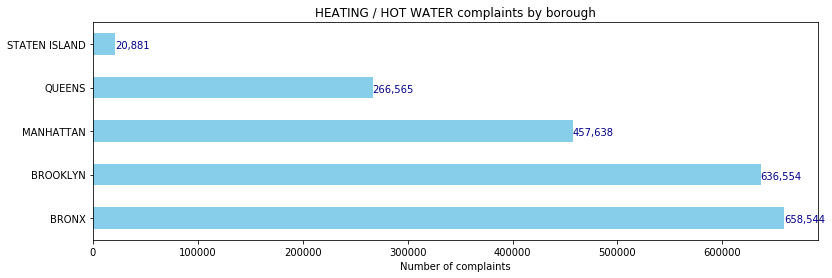

In [26]:
# Graph complaints for each borough.
totals_for_graph = df['borough'].value_counts()
graph_width_max = totals_for_graph.max()
plotted_graph = totals_for_graph.plot(kind='barh', figsize=(13, 4), color='skyblue')
plt.xlim = (0, graph_width_max)
plt.xlabel('Number of complaints')
plt.title('HEATING / HOT WATER complaints by borough')
for index, value in enumerate(totals_for_graph): 
    label_on_bar_text = format(int(value), ',')
    plt.annotate(label_on_bar_text, xy=(value, index - 0.10), color='darkblue')
plt.show()
plt.close()
plotted_graph.clear()

<p style="color:Red;"><b>Insight</b>:  There is a more severe number of heating / hot water complaints in BRONX and BROOKLYN relative to the other boroughs.</p>

In [27]:
# Create a function to draw a bar graph so that it can be used repeatedly to visualize many different things.
def draw_graph(current_borough, current_value):
    graph_width_max = df[df['borough']==current_borough][current_value]
    totals_for_graph = df[df['borough']==current_borough][current_value].value_counts().head(10)
    graph_width_max = totals_for_graph.max()
    plt.figure()
    plotted_graph = totals_for_graph.plot(kind='barh', figsize=(11, 5), color='skyblue')
    plt.xlim = (0, graph_width_max)
    plt.xlabel('Number of complaints')
    plt.title('HEATING / HOT WATER complaints by ' + current_borough + ' ' + current_value)
    for index, value in enumerate(totals_for_graph): 
        label_on_bar_text = format(int(value), ',')
        plt.annotate(label_on_bar_text, xy=(value, index - 0.10), color='darkblue')
    plt.show()
    plt.close()
    plotted_graph.clear()

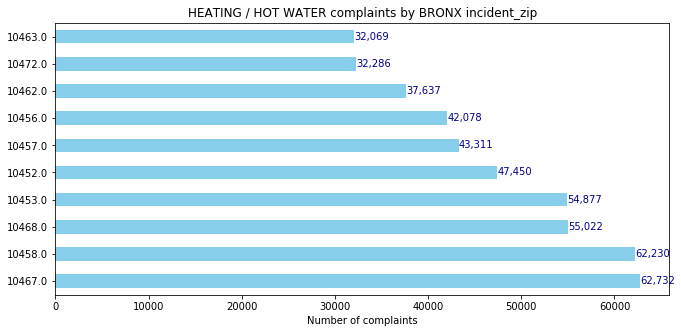

In [28]:
draw_graph("BRONX", "incident_zip")

<p style="color:Red;"><b>Insight</b>:  There are plenty of BRONX ZIP codes with a high number of complaints, but it it highest in ZIP codes:  10458 and 10467.</p>

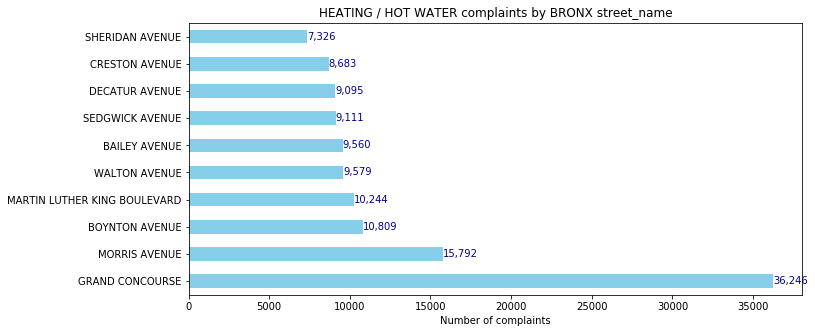

In [29]:
draw_graph("BRONX", "street_name")

<p style="color:Red;"><b>Insight</b>:  In the BRONX borough, there are markedly more complaints on street:  GRAND CONCOURSE.</p>

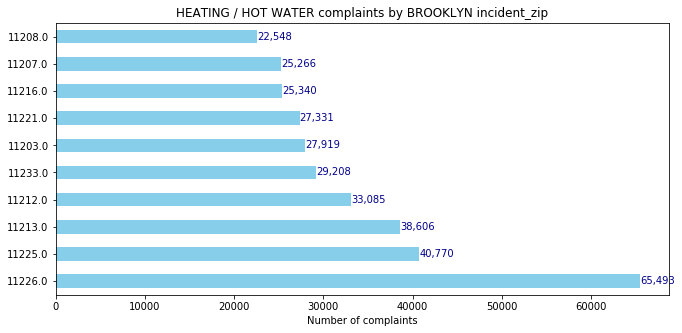

In [30]:
draw_graph("BROOKLYN", "incident_zip")

<p style="color:Red;"><b>Insight</b>:  In the BROOKLYN borough, there are markedly more complaints in ZIP code:  11226.</p>

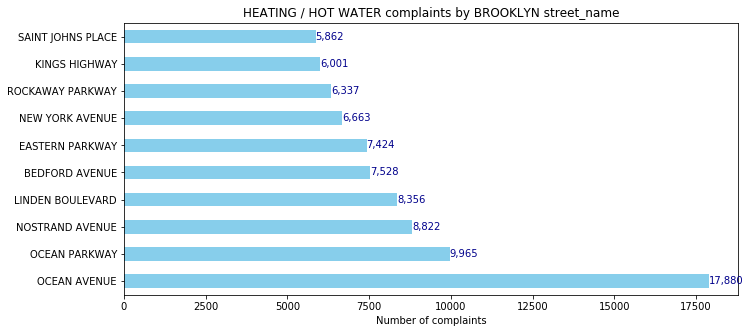

In [31]:
draw_graph("BROOKLYN", "street_name")

<p style="color:Red;"><b>Insight</b>:  In the BROOKLYN borough, there are markedly more complaints on street:  OCEAN AVENUE.</p>

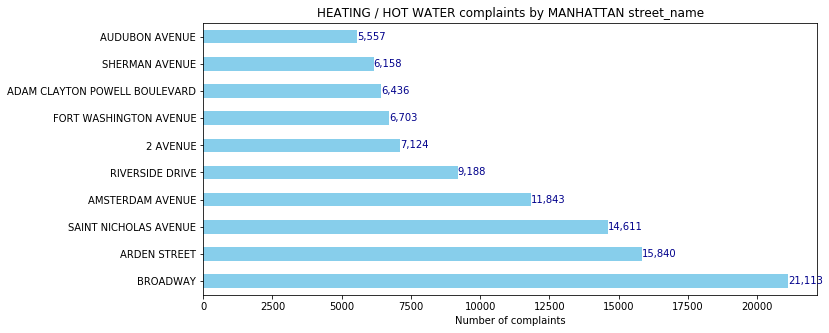

In [32]:
# There was one street in one of the other boroughs noticed during analysis that had a lot of complaints.
draw_graph("MANHATTAN", "street_name")

<p style="color:Red;"><b>Insight</b>:  Even though the MANHATTAN borough as a whole had less complaints than BRONX or BROOKLYN, there were a very large number of complaints on street:  BROADWAY.</p>

<a id="conclusion"></a>
# Concluding Remarks
---

The Department of Housing Preservation and Development of New York City should focus on the BRONX and BROOKLYN boroughs in general.  In the BRONX the focus should first be on ZIP codes 10458 and 10467 and along the street named GRAND CONCOURSE.  In BROOKLYN focus first on ZIP code 11226, but then before moving to OCEAN AVENUE first deal with complaints along BROADWAY in the borough of MANHATTAN.